In [32]:
import numpy as np 
import matplotlib.pyplot as plt # 図の作成環境のロード
from matplotlib import cm # カラーマップ
import time # 計算時間計測プロファイリング用

# 図のテキストにLaTeXを使う
plt.rcParams['text.usetex'] = True

# numbaで高速化
from numba import double
from numba.decorators import jit

In [33]:
# parameters 
# computational domain
Lx=0.1e0
Ly=Lx
# wall velocity
Uwall=0.01
# fluid property
nu=1.e-6 # kinematic viscosity (=mu/rho)
rho=1.e3 # density
# thermal property 
Tbc_H = 1.0
Tbc_L = 0.0
kappa=1.e-5

# nondimensional time (in L/Uwall)
endT=50

# mesh girds
Nx=41
Ny=43

# for dt
CFLv=0.5
CFLk=0.8

# for solver
accel = 1.925e0
err_tol = 1.e-6
tiny = 1.e-20

In [34]:
# set grid 
dx=Lx/np.float(Nx+1)
dy=Ly/np.float(Ny+1)

# mesh information (grid)
x=np.array(np.zeros(Nx+2),dtype=np.float64)
y=np.array(np.zeros(Ny+2),dtype=np.float64)
# cell centre position
xc=np.array(np.zeros(Nx+1),dtype=np.float64)
yc=np.array(np.zeros(Ny+1),dtype=np.float64)

# set uniform mesh
x[0]=0.0
for i in range(1,Nx+2):
    x[i]=x[i-1]+dx; # raw grid
    xc[i-1]=0.5*(x[i-1]+x[i])/Lx # scaled axis of cell centre

y[0]=0.0
for i in range(1,Ny+2):
    y[i]=y[i-1]+dy; # raw grid 
    yc[i-1]=0.5*(y[i-1]+y[i])/Lx # scaled axis of cell centre

dt = min(CFLv*dx/Uwall, CFLk*dx*dx/nu)

Nt = int(endT*Lx/Uwall/dt)

dx2=(dx*dx) 
dy2=(dy*dx) 
dtx2=dt/(dx*dx) 
dty2=dt/(dy*dx)


In [35]:
# variables 
u=np.zeros([Ny+1, Nx+2],dtype=np.float64)
v=np.zeros([Ny+2, Nx+1],dtype=np.float64)
p=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T=np.zeros([Ny+1, Nx+1],dtype=np.float64)

uaux=np.zeros([Ny+1, Nx+2],dtype=np.float64)
vaux=np.zeros([Ny+2, Nx+1],dtype=np.float64)
dive=np.zeros([Ny+1, Nx+1],dtype=np.float64)
#T0=np.zeros([Ny+1, Nx+1],dtype=np.float64)

In [36]:
# Fortran 配列から Namba配列にするには: (i,j) --> [j,i] に変更, 改行(&) --> バックスラッシュ (/)に変更
# 改行コード(/)のあとにスペースが有ると エラーが出る．
# 変数 2.d0 --> 2e0
# 
# numbaで反復計算を高速化
# ---------------------------------------------- #
@jit
def temp_diff(T,T0):
    for j in range(1,Ny):
        for i in range(1,Nx):
            T[j][i]=(1.0-2.0*dtx2-2.0*dty2)*T0[j][i]+dtx2*(T0[j][i+1]+T0[j][i-1])+dty2*(T0[j+1][i]+T0[j-1][i])
# ---------------------------------------------- #
@jit
def calc_aux_u(uaux,u):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            visc = (u[jc, i-1]-2e0*u[jc,i]+u[jc, i+1])/dx2 \
                    +(u[jc-1, i]-2e0*u[jc,i]+u[jc+1, i])/dy2
            conv = (+( ( u[jc, i-1] + u[jc, i])/2e0 \
                              *(-u[jc, i-1]+u[jc, i])/dx ) \
                          +( ( u[jc, i]+u[jc, i+1])/2e0 \
                              *(-u[jc, i]+u[jc, i+1])/dx ) \
                         )/2e0 \
                        +(+( ( v[jc, i-1]+v[jc, i])/2e0 \
                               *(-u[jc-1,i]+u[jc, i])/dy ) \
                            +( ( v[jc+1, i-1] + v[jc+1,i])/2e0 \
                               *(-v[jc,i]+u[jc+1,i])/dy ) \
                         )/2e0
            uaux[jc,i] = u[jc,i] + dt*(-conv + nu*visc)
# ---------------------------------------------- #
@jit            
def calc_aux_v(vaux,v):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            # 
            visc = (v[j-1, ic]-2e0*v[j, ic]+v[j+1, ic])/dy2 \
                    +(v[j, ic-1]-2e0*v[j, ic]+v[j, ic+1])/dx2
            conv = (+( ( u[j-1, ic]+u[j, ic])/2e0 \
                              *(-v[j, ic-1]+v[j, ic])/dx ) \
                          +( ( u[j-1, ic+1]+u[j, ic+1])/2e0 \
                              *(-v[j, ic]+v[j, ic+1])/dx ) \
                         )/2e0 \
                       +(+( ( v[j-1, ic]+v[j, ic])/2e0 \
                              *(-v[j-1, ic]+v[j, ic])/dy ) \
                           +( ( v[j, ic]+v[j+1, ic])/2e0 \
                              *(-v[j, ic]+v[j+1, ic])/dy ) \
                         )/2e0
            vaux[j, ic] = v[j, ic] + dt*(-conv + nu*visc)            
# ---------------------------------------------- #
@jit
def set_bc_v(v):
    # left and right walls        
    for j in range(0,Ny+2):
        v[j,0] = -v[j,1]
        v[j,Nx]= -v[j,Nx-1]

    # bottom and top walls
    for ic in range(0,Nx+1):
        v[1,ic]  =0.e0
        v[Ny,ic] =0.e0
        v[0,ic]  = -v[2,ic]
        v[Ny+1,ic] = -v[Ny-1,ic]
# ---------------------------------------------- #
@jit
def set_bc_u(u):
    # left and right walls
    for jc in range(0,Ny):
        u[jc,1] =0.e0; 
        u[jc,Nx]=0.e0
        u[jc,0] = -u[jc,2] # left imaginary cell
        u[jc,Nx+1] = -u[jc,Nx-1] # right imaginary cell

    # bottom and top walls
    for i in range(0,Nx+2):
        u[0,i] = -u[1,i]  # bottom wall (uc=0)
        u[Ny,i] = -u[Ny-1,i]+2.e0*Uwall # moving wall (uc=Uwall)
# ---------------------------------------------- #
@jit
def divergence(div,u,v):
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            div[jc,ic] = ( (-u[jc,ic] + u[jc, ic+1])/dx \
                       +(-v[jc,ic] + v[jc+1, ic])/dy \
                      )/dt*rho
# ---------------------------------------------- #
@jit
def calcP(p,div):
    err_n=0.0
    err_d=0.0
    for jc in range(1,Ny):
        for ic in range(1,Nx):
            d_pres = (  dy2*(p[jc, ic-1] + p[jc, ic]) \
                             + dx2*(p[jc-1,ic] + p[jc+1,ic]) \
                           - (dx2*dy2 * div[jc,ic]) )/((dx2+dy2)*2e0) - p[jc,ic]
            p[jc,ic] = p[jc,ic] + accel*d_pres
            err_n = err_n + d_pres*d_pres
            err_d = err_d + p[jc,ic]*p[jc,ic]
    set_bc_pressure(p)
    if err_d < tiny:
        err_d = 1e0
    err_r = np.sqrt(err_n/err_d)
    return err_r
# ---------------------------------------------- #
@jit
def set_bc_pressure(p):
    # p[1,1]=0.e0
    for ic in range(1,Nx):
        p[0,ic]= p[1,ic]
        p[Ny,ic]= p[Ny-1,ic]
    for jc in range(1,Ny):
        p[jc,0]=p[jc,1]
        p[jc,Nx]=p[jc,Nx-1]
# ---------------------------------------------- #            
@jit 
def correct_u(u, uaux, p):
    for jc in range(1, Ny):
        for i in range(1, Nx+1):
            u[jc, i] = uaux[jc, i] - dt*(-p[jc, i-1] + p[jc, i])/dx/rho
# ---------------------------------------------- #
@jit
def correct_v(v, vaux, p):
    for j in range(1, Ny+1):
        for ic in range(1, Nx):
            v[j, ic] = vaux[j, ic] - dt*(-p[j-1, ic] + p[j, ic])/dy/rho


In [37]:
# ---------------------------------------------- #
time_ini=time.time()
ifield=0; 
for itr in range(0,Nt):
    t0=time.time()
    calc_aux_u(uaux, u)
    set_bc_u(uaux)
    calc_aux_v(vaux, v)
    set_bc_v(vaux)
    divergence(dive, uaux, vaux)
    
    err_r=1.e0
    itr_SOR=0
    while err_r > err_tol:
        itr_SOR += 1
        err_r=calcP(p, dive)
        if itr < 10: 
            if itr_SOR >1000: 
                break
        elif itr < 20: 
            if itr_SOR >5000: 
                break        
        elif itr < 30: 
            if itr_SOR >10000: 
                break
    if np.isnan(err_r)==1:
        print('NaN: at itr='+str(itr))
        break
    if np.mod(itr,100)==0:
        ifield += 1
        print('istep='+str(itr)+':  calcP: itr='+str(itr_SOR)+', error='+str(err_r))
        filename='field_'
        #fig.savefig(filename+'%04d'%ifield+'.png')
        
    correct_u(u, uaux, p)
    set_bc_u(u)
    correct_v(v, vaux, p)
    set_bc_v(v)
    
    
    t1=time.time()
    #print('time elapsed:'+str(t1-t0)+' sec.,')
print('time elapsed:'+str(t1-time_ini)+' sec.,'+' nstep='+str(itr))

istep=0:  calcP: itr=1, error=0.0
istep=100:  calcP: itr=43, error=9.219168371803335e-07
istep=200:  calcP: itr=44, error=8.88387831833713e-07
istep=300:  calcP: itr=43, error=9.883015993270052e-07
istep=400:  calcP: itr=41, error=9.62170961917321e-07
istep=500:  calcP: itr=187, error=9.985777115312493e-07
istep=600:  calcP: itr=41, error=8.553169653876903e-07
istep=700:  calcP: itr=153, error=9.963419786804278e-07
istep=800:  calcP: itr=41, error=9.057812064702916e-07
istep=900:  calcP: itr=63, error=9.983001860727858e-07
istep=1000:  calcP: itr=40, error=9.494759387716869e-07
istep=1100:  calcP: itr=44, error=9.613564395192882e-07
istep=1200:  calcP: itr=99, error=9.968676035878428e-07
istep=1300:  calcP: itr=43, error=9.779916190689934e-07
istep=1400:  calcP: itr=44, error=8.857681160560391e-07
istep=1500:  calcP: itr=44, error=9.964287176288438e-07
istep=1600:  calcP: itr=46, error=9.119766926671977e-07
istep=1700:  calcP: itr=100, error=9.960287711941018e-07
istep=1800:  calcP: it

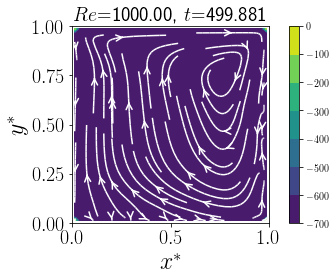

In [39]:
uc=np.array(np.zeros((Ny+1,Nx+1),dtype=np.float64))
vc=np.array(np.zeros((Ny+1,Nx+1),dtype=np.float64))
# interpolate
uc=0.5*(u[:,:-1]+u[:,1:])/Uwall # interpolate at the cell centre with scaling
vc=0.5*(v[:-1,:]+v[1:,:])/Uwall # interpolate at the cell centre with scaling

x2d, y2d = np.meshgrid(xc,yc)
# Controlling the starting points of the streamlines

seed_points = np.array([x2d[::4,::4].reshape(121), y2d[::4,::4].reshape(121)])
# 結果の図示
# plot streamlines and pressure field
fig, ax = plt.subplots()
tcf = ax.contourf(xc, yc, p)
fig.colorbar(tcf)

ax.streamplot(x2d,y2d,uc,vc,color='w',integration_direction='both',arrowsize=1.5,arrowstyle="->",
               minlength=0.2,maxlength=0.8,start_points=seed_points.T)

#ax.streamplot(xc,yc,uc,vc,color='w',density=1,integration_direction='backward',arrowstyle="->")
ax.set_aspect('equal')
plt.xlim(0, 1); plt.ylim(0, 1)
ax.set_title("$Re$={0:.2f}".format(Uwall*Ly/nu)+", $t$={0:.3f}".format(itr*dt),fontsize=20)
ax.set_xlabel('$x^*$',fontsize=24)
ax.set_ylabel("$y^*$",fontsize=24)
ax.tick_params(labelsize=20)
ax.set_aspect('equal')
plt.tight_layout()

plt.show()